# Загрузка библиотек

In [1]:
import pandas as pd
print ('pandas ' + str(pd.__version__))
import joblib
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

pandas 1.5.3


In [2]:
import numpy as np
print ('numpy ' + str(np.__version__))
import seaborn as sns
print ('seaborn ' + str(sns.__version__))

numpy 1.23.5
seaborn 0.12.2


## Загрузка данных

In [6]:
from google.colab import drive
drive.mount('/content/gdrive/')
train_df = pd.read_parquet('/content/gdrive/My Drive/Colab Notebooks/Alfa/train.parquet')

#test_df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Alfa/target_1.csv')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [7]:
test_df = pd.read_parquet('/content/gdrive/My Drive/Colab Notebooks/Alfa/test.parquet')


#Загрузка данных локально

In [ ]:
train_df = pd.read_parquet('train.parquet')
test_df = pd.read_parquet('test.parquet')

In [8]:
train_df

,id,rko_start_months,max_end_fact_fin_deals,max_end_plan_non_fin_deals,max_start_fin_deals,max_start_non_fin_deals,min_end_fact_fin_deals,min_end_plan_non_fin_deals,min_start_fin_deals,min_start_non_fin_deals,...,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,target_1,target_2,total_target
0,0,-1.279132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.352516,-0.081310,0.210189,1.140808,0.647477,0.810887,1.909568,0,0,0
1,1,-1.142591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.188287,-0.650616,-0.316563,-1.136536,-0.127326,-0.147319,-0.517805,0,0,0
2,2,1.812270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.323487,0.632731,2.541558,3.017482,0.033394,0.019972,0.578428,0,0,0
3,3,-0.479407,NaN,0.356677,NaN,-0.332867,NaN,-0.704164,NaN,0.905748,...,-0.323487,-0.003549,-0.219016,0.228624,-0.428185,-0.220932,-0.596108,0,0,0
4,4,-1.503690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.323487,0.182726,-0.287299,-0.528921,-0.563335,-0.021506,-0.361201,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,299995,0.140494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.082114,0.276906,0.346755,1.535162,0.718633,-0.242059,-0.047991,0,0,0
299996,299996,-0.578334,NaN,-0.773909,NaN,0.182200,NaN,-0.690771,NaN,-0.519096,...,-0.323487,-0.264553,-0.316563,-0.472916,-0.053175,0.222753,-0.596108,0,0,0
299997,299997,2.052711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.323487,0.139359,-0.316563,-0.768966,-0.115407,-0.054465,-0.047991,0,0,0
299998,299998,1.051685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.188287,-0.122459,-0.316563,-0.317586,0.829699,-0.416806,-0.596108,0,1,1


#Подсчет пропущенных значений в train_df

In [6]:
train_df.isnull().sum().to_frame()

,0
id,0
rko_start_months,56
max_end_fact_fin_deals,263086
max_end_plan_non_fin_deals,287521
max_start_fin_deals,263086
...,...
cnt_cred_h_oper_3m,3131
cnt_days_cred_h_oper_3m,3131
target_1,0
target_2,0


#Удаление данных, если считать выбросами все точки, выходящие за пределы трёх сигм. (Привело к уменььшению ROC-AUC)

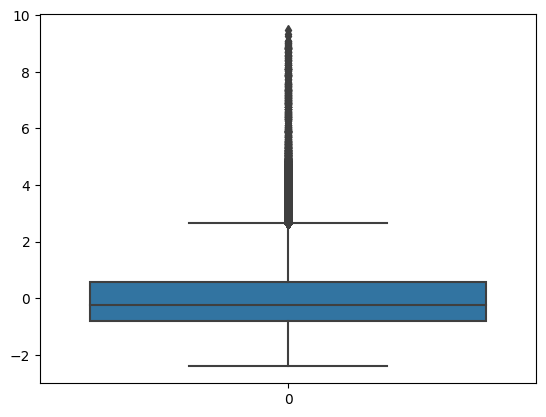

In [ ]:
sns.boxplot(train_df['rko_start_months']);

In [ ]:
def outliers_indices(feature):

    mid = train_df[feature].mean()
    sigma = train_df[feature].std()
    return train_df[(train_df[feature] < mid - 3*sigma) | (train_df[feature] > mid + 3*sigma)].index

In [ ]:
wrong_rko = outliers_indices('rko_start_months')

In [ ]:
train_df.drop(wrong_rko, inplace=True)

#Попытка найти фичи с помощью VarianceThreshold

In [ ]:
train = pd.DataFrame()
train = train_df.drop(columns = ["id",'target_1', 'target_2', 'total_target','channel_code', 'city', 'city_type',
    'index_city_code', 'ogrn_month', 'ogrn_year',
    'branch_code', 'okved', 'segment', 'ogrn_exist_months'], axis=1).copy()


In [ ]:
from sklearn.feature_selection import VarianceThreshold

In [ ]:
selector = VarianceThreshold(threshold=(.8 * (1 - .8)))
selector.fit_transform(train)

array([[-1.27913247,         nan,         nan, ...,  0.64747724,
         0.81088679,  1.90956848],
       [-1.14259057,         nan,         nan, ..., -0.12732578,
        -0.14731946, -0.51780527],
       [ 1.81227018,         nan,         nan, ...,  0.03339432,
         0.01997184,  0.57842804],
       ...,
       [ 2.05271089,         nan,         nan, ..., -0.11540738,
        -0.05446501, -0.047991  ],
       [ 1.05168539,         nan,         nan, ...,  0.82969912,
        -0.41680562, -0.59610765],
       [-0.64235715,         nan,         nan, ...,  0.61590093,
        -0.21398245, -0.047991  ]])

In [ ]:
from sklearn.feature_selection import SelectPercentile

## Обработка данных

Поиск оптимальных признаков для разных таргетов и преобразование категориальных признаков

In [9]:
cat_cols = [
    'channel_code', 'city', 'city_type',
    'index_city_code', 'ogrn_month', 'ogrn_year',
    'branch_code', 'okved', 'segment'
]

In [10]:
train_df[cat_cols] = train_df[cat_cols].astype("category")

In [11]:
#For total_target 0.8829194986465275 / 0.860776218 best 8825          Признаки, без которых мы получили лучший результат
train_df.drop(["id", "target_1", "target_2", 'channel_code', 'city',
    'index_city_code','ogrn_month', 'ogrn_year', 'branch_code',
       'ogrn_days_end_month', 'ogrn_days_end_quarter','min_end_fact_fin_deals',
               'min_end_plan_non_fin_deals', 'min_start_fin_deals', 'min_start_non_fin_deals',
               'ft_registration_date'], axis=1, inplace=True)

In [ ]:
#For total_target
train_df.drop(["id", "target_1", "target_2", 'channel_code', 'city',
    'index_city_code','ogrn_month', 'ogrn_year', 'branch_code',
       'ogrn_days_end_month', 'ogrn_days_end_quarter',
               'ft_registration_date'], axis=1, inplace=True)

In [ ]:
#For target_1
train_df.drop(["id", "total_target", "target_2", 'channel_code', 'city',
    'index_city_code','ogrn_month', 'ogrn_year', 'branch_code', 'ogrn_days_end_month',
               'ogrn_days_end_quarter','cnt_cred_d_oper_1m',
'sum_cred_e_oper_1m',
'cnt_cred_e_oper_1m',
'cnt_days_cred_e_oper_1m',
'sum_cred_f_oper_1m',
'cnt_cred_f_oper_1m',
'cnt_days_cred_f_oper_1m',
'sum_cred_g_oper_1m',
'cnt_cred_g_oper_1m',
'cnt_days_cred_g_oper_1m',
'sum_cred_h_oper_1m',
'cnt_cred_h_oper_1m',
'cnt_days_cred_h_oper_1m',
'sum_cred_d_oper_3m',
'cnt_cred_d_oper_3m',
'sum_cred_e_oper_3m',
'cnt_cred_e_oper_3m',
'cnt_days_cred_e_oper_3m',
'sum_cred_f_oper_3m',
'cnt_cred_f_oper_3m',
'cnt_days_cred_f_oper_3m',
'sum_cred_g_oper_3m',
'cnt_cred_g_oper_3m',
'cnt_days_cred_g_oper_3m',
'sum_cred_h_oper_3m',
'cnt_cred_h_oper_3m',
'cnt_days_cred_h_oper_3m',

               'ft_registration_date' ], axis=1, inplace=True)

In [ ]:
#For total_target 0.8831112421298863 / 0.8596806884 bad
train_df.drop(["id", "target_1", "target_2", 'channel_code', 'city',
    'index_city_code','ogrn_month', 'ogrn_year', 'branch_code',
       'min_end_fact_fin_deals', 'min_end_plan_non_fin_deals', 'min_start_fin_deals', 'min_start_non_fin_deals',
               'ft_registration_date' ], axis=1, inplace=True)

In [ ]:
#For total_target 0.8824096460901996 /
train_df.drop(["id", "target_1", "target_2", 'channel_code', 'city',
    'index_city_code','ogrn_month', 'ogrn_year', 'branch_code',
      'segment', 'ogrn_days_end_month', 'ogrn_days_end_quarter','min_end_fact_fin_deals',
               'min_end_plan_non_fin_deals', 'min_start_fin_deals', 'min_start_non_fin_deals',
               'ft_registration_date'], axis=1, inplace=True)

In [ ]:
#For total_target 0.8782371981466639
train_df.drop(["id", "target_1", "target_2", 'channel_code', 'city', 'city_type',
    'index_city_code', 'ogrn_month', 'ogrn_year',
    'branch_code', 'okved', 'segment', 'ogrn_exist_months'], axis=1, inplace=True) #0.8782371981466639
# 'cnt_days_deb_e_oper_1m',
               #'cnt_days_cred_e_oper_1m', 'cnt_days_deb_f_oper_1m', 'cnt_days_deb_g_oper_1m', 'cnt_days_deb_h_oper_1m',
               #'cnt_days_cred_h_oper_1m', 'cnt_days_deb_e_oper_3m', 'cnt_days_cred_e_oper_3m','cnt_days_deb_f_oper_3m',
               #'cnt_days_deb_g_oper_3m', 'cnt_days_deb_h_oper_3m', 'cnt_days_cred_h_oper_3m'


In [ ]:
#For total_target 0.8810752952829072
train_df.drop(["id", "target_1", "target_2", 'channel_code', 'city',
    'index_city_code','ogrn_month', 'ogrn_year', 'branch_code',
     'okved', 'segment', 'ogrn_days_end_month',
               'ogrn_days_end_quarter', 'max_end_fact_fin_deals', 'max_end_plan_non_fin_deals',
               'max_start_fin_deals', 'max_start_non_fin_deals', 'min_end_fact_fin_deals',
               'min_end_plan_non_fin_deals', 'min_start_fin_deals', 'min_start_non_fin_deals',
               'balance_amt_avg',
               'ft_registration_date' ], axis=1, inplace=True)

In [ ]:
#For total_target 0.8820869495785688      /      0.86
train_df.drop(["id", "target_1", "target_2", 'channel_code', 'city',
    'index_city_code','ogrn_month', 'ogrn_year', 'branch_code',
      'segment', 'ogrn_days_end_month', 'ogrn_days_end_quarter',
               'ft_registration_date'], axis=1, inplace=True)

In [ ]:
#For total_target 0.8748805896917231
train_df.drop(["id", "target_1", "target_2", 'channel_code', 'city', 'city_type',
    'index_city_code', 'ogrn_month', 'ogrn_year',
    'branch_code', 'okved', 'segment', 'ogrn_days_end_month', 'ogrn_days_end_quarter',
               'ft_registration_date'
               ], axis=1, inplace=True)

In [ ]:
#For total_target 0.881397330083552
train_df.drop(["id", "target_1", "target_2", 'channel_code', 'city',
    'index_city_code', 'ogrn_month', 'ogrn_year',
    'branch_code', 'okved', 'segment', 'ogrn_days_end_month', 'ogrn_days_end_quarter',
               'ft_registration_date'
               ], axis=1, inplace=True)

In [ ]:
#For total_target 0.8765390916986429
train_df.drop(["id", "target_1", "target_2", 'channel_code', 'city', 'city_type',
    'index_city_code', 'ogrn_month', 'ogrn_year',
    'branch_code', 'okved', 'segment', 'ogrn_exist_months', 'ogrn_days_end_quarter'], axis=1, inplace=True)

In [ ]:
#For total_target 0.8761046293608197
train_df.drop(["id", "target_1", "target_2", 'channel_code', 'city', 'city_type',
    'index_city_code', 'ogrn_month', 'ogrn_year',
    'branch_code', 'okved', 'segment'], axis=1, inplace=True)

In [ ]:
#For total_target2
train_df2 = pd.DataFrame()
train_df2 = train_df[['branch_code','sum_a_oper_1m','sum_b_oper_1m','sum_c_oper_1m',
         'sum_deb_d_oper_1m','sum_cred_d_oper_1m','sum_deb_e_oper_1m',
         'sum_cred_e_oper_1m','sum_deb_f_oper_1m','sum_cred_f_oper_1m',
         'sum_deb_g_oper_1m','sum_deb_h_oper_1m','sum_cred_h_oper_1m',
         'sum_a_oper_3m','sum_b_oper_3m','sum_c_oper_3m','sum_deb_d_oper_3m',
         'sum_cred_d_oper_3m','sum_deb_e_oper_3m','sum_cred_e_oper_3m',
         'sum_deb_f_oper_3m','sum_cred_f_oper_3m','sum_deb_g_oper_3m',
         'sum_cred_g_oper_3m','sum_deb_h_oper_3m','sum_cred_h_oper_3m',
         'total_target']].copy()

In [ ]:
#For total_target
train_df.drop(["id", "target_1", "target_2", 'channel_code', 'city',
    'index_city_code','ogrn_month', 'ogrn_year', 'branch_code',
      'segment', 'ogrn_days_end_month', 'ogrn_days_end_quarter','min_end_fact_fin_deals',
               'min_end_plan_non_fin_deals', 'min_start_fin_deals', 'min_start_non_fin_deals',
               'ft_registration_date', 'cnt_cred_d_oper_1m', 'sum_cred_e_oper_1m',
               'cnt_cred_e_oper_1m', 'cnt_days_cred_e_oper_1m', 'sum_cred_f_oper_1m',
'cnt_cred_f_oper_1m',
'cnt_days_cred_f_oper_1m',
'sum_cred_g_oper_1m',
'cnt_cred_g_oper_1m',
'cnt_days_cred_g_oper_1m',
'sum_cred_h_oper_1m',
'cnt_cred_h_oper_1m',
'cnt_days_cred_h_oper_1m',
'sum_cred_d_oper_3m',
'cnt_cred_d_oper_3m',
'sum_cred_e_oper_3m',
'cnt_cred_e_oper_3m',
'cnt_days_cred_e_oper_3m',
'sum_cred_f_oper_3m',
'cnt_cred_f_oper_3m',
'cnt_days_cred_f_oper_3m',
'sum_cred_g_oper_3m',
'cnt_cred_g_oper_3m',
'cnt_days_cred_g_oper_3m',
'sum_cred_h_oper_3m',
'cnt_cred_h_oper_3m',
'cnt_days_cred_h_oper_3m'
 ], axis=1, inplace=True)

In [ ]:
#For target_1
train_df.drop(["id", "total_target", "target_2"], axis=1, inplace=True)

In [ ]:
#For target_2
train_df.drop(["id", "target_1", "total_target"], axis=1, inplace=True)

In [ ]:
#For target_22
train_df.drop(["id", "target_1", "total_target", 'channel_code', 'city', 'city_type',
    'index_city_code', 'ogrn_month', 'ogrn_year',
    'branch_code', 'okved', 'segment', 'ogrn_exist_months', 'cnt_days_deb_e_oper_1m',
               'cnt_days_cred_e_oper_1m', 'cnt_days_deb_f_oper_1m', 'cnt_days_deb_g_oper_1m', 'cnt_days_deb_h_oper_1m', '' ], axis=1, inplace=True)

In [ ]:
train_df2 = pd.DataFrame()
train_df2['ogrn_exist_months'] = train_df['ogrn_exist_months']
train_df2['cnt_days_deb_e_oper_1m'] = train_df['cnt_days_deb_e_oper_1m']
train_df2['cnt_days_cred_e_oper_1m'] = train_df['cnt_days_cred_e_oper_1m']
train_df2['cnt_days_deb_f_oper_1m'] = train_df['cnt_days_deb_f_oper_1m']
train_df2['cnt_days_deb_g_oper_1m'] = train_df['cnt_days_deb_g_oper_1m']
train_df2['cnt_days_deb_h_oper_1m'] = train_df['cnt_days_deb_h_oper_1m']
train_df2['cnt_days_cred_h_oper_1m'] = train_df['cnt_days_cred_h_oper_1m']
train_df2['cnt_days_deb_e_oper_3m'] = train_df['cnt_days_deb_e_oper_3m']
train_df2['cnt_days_cred_e_oper_3m'] = train_df['cnt_days_cred_e_oper_3m']
train_df2['cnt_days_deb_f_oper_3m'] = train_df['cnt_days_deb_f_oper_3m']
train_df2['cnt_days_deb_g_oper_3m'] = train_df['cnt_days_deb_g_oper_3m']
train_df2['cnt_days_deb_h_oper_3m'] = train_df['cnt_days_deb_h_oper_3m']
train_df2['cnt_days_cred_h_oper_3m'] = train_df['cnt_days_cred_h_oper_3m']
train_df2['total_target'] = train_df['total_target']


## Разбиение на train, validation для разных таргетов

In [12]:
#For total_target
X = train_df.drop("total_target", axis=1)
y = train_df.total_target
x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.3,
                                                  random_state=12)

In [ ]:
#For target_1
X = train_df.drop("target_1", axis=1)
y = train_df.target_1
x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

In [ ]:
#For target_2
X = train_df.drop("target_2", axis=1)
y = train_df.target_2
x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.3,
                                                  random_state=42)

In [ ]:
#For train
X = train
y = train_df.total_target
x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.3,
                                                  random_state=42)

# Обучение модели LGBMClassifier

In [13]:
model = LGBMClassifier(max_depth=-1, n_estimators=100, reg_alpha=10, reg_lambda=10, subsample_for_bin=200000, num_leaves=31, random_state=12)
model.set_params(n_jobs=5)
model.fit(x_train, y_train)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 14818, number of negative: 195182
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.323770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19539
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 86
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.070562 -> initscore=-2.578090
[LightGBM] [Info] Start training from score -2.578090


LGBMClassifier(n_jobs=5, random_state=12, reg_alpha=10, reg_lambda=10)

In [14]:
y_pred = model.predict_proba(x_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8835824674631321

#Предсказание для тестовой выборки и загрузка результата в файл csv

In [15]:
test_df[cat_cols] = test_df[cat_cols].astype("category")

In [16]:
test_score = model.predict_proba(test_df.drop(["id", 'channel_code', 'city',
    'index_city_code','ogrn_month', 'ogrn_year', 'branch_code',
       'ogrn_days_end_month', 'ogrn_days_end_quarter','min_end_fact_fin_deals',
               'min_end_plan_non_fin_deals', 'min_start_fin_deals', 'min_start_non_fin_deals',
               'ft_registration_date'], axis=1))[:, 1]

In [ ]:
# Только с selector.fit_transform

test_score = model.predict_proba(selector.fit_transform(test_df.drop(["id", 'channel_code', 'city',
    'index_city_code','ogrn_month', 'ogrn_year', 'branch_code',
       'min_end_fact_fin_deals', 'min_end_plan_non_fin_deals', 'min_start_fin_deals', 'min_start_non_fin_deals',
               'ft_registration_date'], axis=1)))[:, 1]

In [ ]:
#For target_1

new_pred = test_df.copy()
new_pred["target_1"] = test_score


In [ ]:
#For target_2

new_pred = test_df.copy()
new_pred["target_2"] = test_score


In [17]:
#For total_target

new_pred = test_df.copy()
new_pred["total_target"] = test_score

In [18]:
new_pred

,id,rko_start_months,max_end_fact_fin_deals,max_end_plan_non_fin_deals,max_start_fin_deals,max_start_non_fin_deals,min_end_fact_fin_deals,min_end_plan_non_fin_deals,min_start_fin_deals,min_start_non_fin_deals,...,sum_cred_g_oper_3m,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,total_target
0,300000,-1.076009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.045603,-0.131653,-0.323487,-0.169940,-0.316563,-0.639934,-0.171600,-0.237763,-0.596108,0.345422
1,300001,-0.335070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.045603,-0.131653,-0.323487,-0.169940,-0.316563,-0.639934,-0.171580,-0.222361,-0.517805,0.611311
2,300002,0.920834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.045603,-0.131653,-0.323487,-0.169940,-0.316563,-0.639934,0.020943,-0.160754,-0.204596,0.014087
3,300003,-0.772897,-0.740714,NaN,-0.635375,NaN,-0.595302,NaN,-0.738424,NaN,...,-0.045603,-0.131653,-0.323487,-0.137993,-0.277545,-0.381706,-0.171600,-0.237763,-0.596108,0.017166
4,300004,-0.665342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.045603,-0.131653,-0.323487,-0.139926,-0.277545,-0.381706,-0.158918,-0.222361,-0.517805,0.005735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,399995,-0.462181,-0.655619,NaN,-0.615833,NaN,0.252559,NaN,-0.269155,NaN,...,-0.044762,-0.101828,-0.188287,0.035977,-0.258035,-0.317149,-0.060968,-0.068343,0.108614,0.020675
99996,399996,1.162020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.045250,-0.101828,-0.188287,-0.169707,-0.258035,-0.446263,-0.077180,0.024067,0.265219,0.020710
99997,399997,-0.277489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.045603,-0.131653,-0.323487,-0.169940,-0.316563,-0.639934,-0.171600,-0.237763,-0.596108,0.032033
99998,399998,-0.743564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.045603,-0.131653,-0.323487,-0.169940,-0.316563,-0.639934,-0.142708,-0.022138,0.421823,0.032789


In [ ]:
#только с target_1
submiss = pd.DataFrame()
submiss['id'] = test_df['id'].copy()
submiss['score'] = test_df['target_1'].copy()

In [ ]:
#только с target_2

submiss = pd.DataFrame()
submiss['id'] = new_pred['id'].copy()
submiss['score'] = new_pred['total_target'].copy()
submiss

In [ ]:
#только с total_target
submiss = pd.DataFrame()
submiss['id'] = new_pred['id'].copy()
submiss['score'] = new_pred['total_target'].copy()

In [ ]:
submiss.to_csv('/content/gdrive/My Drive/Colab Notebooks/Alfa/submiss_tt_8835_test03.csv')

Нахождение максимального значения между target_1 и target_2

In [ ]:
def max_of(first, second):
  if first > second:
    return first
  else:
    return second

In [ ]:
new_pred['score'] = new_pred.apply(lambda row: max_of(row['target_1'], row['target_2']),axis=1)